In [1]:
import numpy as np
import pandas as pd
import ast

from gensim import corpora
import gensim
import pyLDAvis.gensim

from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

import time
from tqdm.notebook import tqdm
import warnings

import matplotlib.pyplot as plt

## 여행지 키워드 전처리

In [2]:
tour = pd.read_csv("./final_data/전체_final_data_edit.csv", encoding = 'utf-8-sig')

# 각 행의 키워드를 문자열 형태로 만들어주기 위해 인덱스 초기화(인덱스 활용 접근)
tour.reset_index()

# 각 행의 키워드들을 문자열화
for i in range(tour.shape[0]):  
    keyword = tour.loc[i, 'keyword'].replace("'관광지'", "")
    keyword = keyword.replace('[', '').replace(']', '').replace("'", "")
    keyword = keyword.replace(' ', '').split(',')
    keyword = list(set(keyword))
    keyword = ' '.join(keyword)
    tour.loc[i, 'keyword'] = keyword
    if tour.loc[i, 'keyword'] == '':
        tour.loc[i, 'keyword'] = np.nan

tour.head()

,name,region,tel,keyword,photo,address,lat,lon
0,(구)강경노동조합,충남 논산시,041-746-5412,등록문화재 건축여행 근대건축물,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,충청남도 논산시 강경읍 옥녀봉로27번길 30-5,36.160849,127.014602
1,(구)인천일본제58은행지점,인천 중구,032-760-6474,문화재 교과서속여행 역사,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,인천광역시 중구 신포로23번길 77,37.472859,126.621154
2,(구)태백등기소,강원 태백시,166,NaN,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,강원도 태백시 하장성 1길 14,37.102615,129.020972
3,(구)한일은행 강경지점,충남 논산시,041-746-5412,역사공부 근대건축물 건축여행 역사,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,충청남도 논산시 강경읍 계백로167번길 50,36.162130,127.015154
4,(전)광주 성거사지 오층석탑,광주 남구,062-607-2333,역사공부 탑 보물 역사관광지,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,광주광역시 남구 천변좌로338번길 7,35.147999,126.908710


In [3]:
tour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14060 entries, 0 to 14059
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     14060 non-null  object 
 1   region   14060 non-null  object 
 2   tel      13904 non-null  object 
 3   keyword  13782 non-null  object 
 4   photo    14060 non-null  object 
 5   address  14060 non-null  object 
 6   lat      14060 non-null  float64
 7   lon      14060 non-null  float64
dtypes: float64(2), object(6)
memory usage: 878.9+ KB


In [4]:
# tfidf 벡터에 없는 키워드만 가진 여행지 제거하기 위한 작업
tour['tel'].fillna(value=0, inplace=True)

In [5]:
# tfidf 벡터에 없는 키워드만 가진는 모든 topic의 값이 null 값이므로 제거
tour.dropna(inplace=True)

In [6]:
tour.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13782 entries, 0 to 14059
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   name     13782 non-null  object 
 1   region   13782 non-null  object 
 2   tel      13782 non-null  object 
 3   keyword  13782 non-null  object 
 4   photo    13782 non-null  object 
 5   address  13782 non-null  object 
 6   lat      13782 non-null  float64
 7   lon      13782 non-null  float64
dtypes: float64(2), object(6)
memory usage: 969.0+ KB


In [7]:
# 여행지 제거 후 인덱스 초기화
tour.reset_index(drop=True, inplace=True)

## gensim

In [8]:
# 데이터프레임을 번호로 접근하기 위해 인덱스 초기화
tour.reset_index()

documents = []
processed_data = []

# 키워드 학습을 위해 문서 list에 keyword list 추가
for i in range(tour.shape[0]):
    documents.append(tour.loc[i, 'keyword'].split())

# ldamodel을 위한 dictionary, corpus 선언, 그리고 coherence 출력을 위한 processed_data 선언
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(text, allow_update=True) for text in documents]
processed_data = [text for text in documents]

# print(dictionary)

# for c in corpus:
#     print(c)

In [9]:
# ldamodel 초기화
num_topics = 10
chunksize = 1000
passes = 20
iterations = 400
eval_every = None


%time model = LdaModel(corpus = corpus, id2word = dictionary, chunksize = chunksize, alpha ="auto", eta="auto",iterations = iterations, num_topics = num_topics, passes = passes, eval_every = eval_every)


Wall time: 35.9 s


In [10]:
# ldamodel coherence, perplexity 출력
cm = CoherenceModel(model=model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()
print("Cpherence",coherence)
print('\nPerplexity: ', model.log_perplexity(corpus))

Cpherence -12.88564338586809

Perplexity:  -5.725478828724387


In [ ]:
# ldamodel passes 수 구하기
coherences=[]
perplexities=[]
warnings.filterwarnings('ignore')

for i in tqdm(range(100)):
    
    ntopics, nwords = 35, 100
    if i==0:
        p=1
    else:
        p=i
    tic = time.time()
    lda4 = LdaModel(corpus, id2word=dictionary, num_topics=ntopics, iterations=400, passes=p)
    print('epoch',p,time.time() - tic)
    # tfidf, corpus 무슨 차이?
    # lda = models.ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=ntopics, iterations=200000)

    cm = CoherenceModel(model=lda4, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherences.append(coherence)
    print('Perplexity: ', lda4.log_perplexity(corpus),'\n\n')
    perplexities.append(lda4.log_perplexity(corpus))

In [ ]:
# ldamodel passes, coherence 그래프
plt.figure(figsize=(20, 10))
plt.plot(coherences,label='passes coherence relationship', color='green')
plt.xlabel('passes', fontsize=30)
plt.ylabel('coherence', fontsize=30)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [ ]:
# ldamodel passes, perplexity 그래프
plt.figure(figsize=(20, 10))
plt.plot(perplexities,label='passes perplexity relationship', color='green')
plt.xlabel('passes', fontsize=30)
plt.ylabel('perplexity', fontsize=30)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [12]:
# ldamodel topic 수 구하기
coherencesT=[]
perplexitiesT=[]
passes=[]
warnings.filterwarnings('ignore')

for i in tqdm(range(100)):
    if i==0:
        ntopics = 2
    else:
        ntopics = i
    nwords = 100
    tic = time.time()
    lda4 = LdaModel(corpus, id2word=dictionary, num_topics=ntopics, iterations=400, passes=26)
    print('ntopics',ntopics,time.time() - tic)

    cm = CoherenceModel(model=lda4, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherencesT.append(coherence)
    print('Perplexity: ', lda4.log_perplexity(corpus),'\n\n')
    perplexitiesT.append(lda4.log_perplexity(corpus))

ntopics 2 46.69163131713867
Cpherence -6.311268118579177
Perplexity:  -5.583862922987681 


ntopics 1 28.41869831085205
Cpherence -7.84370970627003
Perplexity:  -5.774754903052538 


ntopics 2 51.017043352127075
Cpherence -6.007933879050276
Perplexity:  -5.590021313044308 


ntopics 3 47.12756562232971
Cpherence -7.383053641467992
Perplexity:  -5.482364131717639 


ntopics 4 53.45087647438049
Cpherence -9.640449746806574
Perplexity:  -5.518610665396115 


ntopics 5 51.95263123512268
Cpherence -7.701767605318892
Perplexity:  -5.448250774208991 


ntopics 6 49.399654150009155
Cpherence -8.9506893055365
Perplexity:  -5.439768592287889 


ntopics 7 55.29211616516113
Cpherence -9.970246353735197
Perplexity:  -5.4869319544414825 


ntopics 8 54.641080379486084
Cpherence -9.655236066322846
Perplexity:  -5.4124989068783425 


ntopics 9 54.51941132545471
Cpherence -12.064477779441019
Perplexity:  -5.39402611911234 


ntopics 10 51.556015491485596
Cpherence -11.130702724618484
Perplexity:  -5.41

Perplexity:  -24.97616131530797 


ntopics 88 131.14137387275696
Cpherence -18.422582269589068
Perplexity:  -25.8283290064794 


ntopics 89 136.90322709083557
Cpherence -18.511250757654313
Perplexity:  -26.807906491953208 


ntopics 90 139.87400913238525
Cpherence -18.3518865138813
Perplexity:  -27.110181491587998 


ntopics 91 136.3364396095276
Cpherence -18.367387209582763
Perplexity:  -28.699822082888915 


ntopics 92 140.90921115875244
Cpherence -18.391774843344873
Perplexity:  -29.341552376226375 


ntopics 93 139.174818277359
Cpherence -18.312473375936765
Perplexity:  -31.85261562203869 


ntopics 94 133.77030110359192
Cpherence -18.282861066682017
Perplexity:  -31.416611943088725 


ntopics 95 133.48107194900513
Cpherence -18.195840729202445
Perplexity:  -33.52384307708265 


ntopics 96 90.93966460227966
Cpherence -18.17762573188027
Perplexity:  -37.03217187361538 


ntopics 97 90.22075247764587
Cpherence -18.184643826559007
Perplexity:  -38.90881237635351 


ntopics 98 96.19976

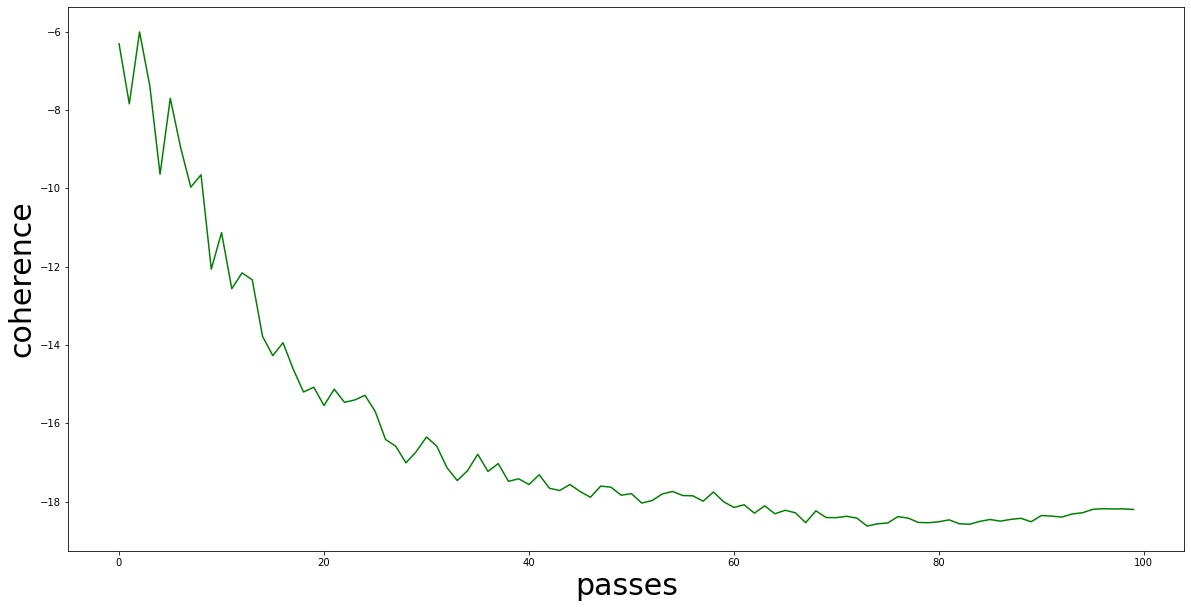

In [13]:
# ldamodel ntopics, coherence 그래프
plt.figure(figsize=(20, 10))
plt.plot(coherencesT,label='ntopics coherence relationship', color='green')
plt.xlabel('ntopics', fontsize=30)
plt.ylabel('coherence', fontsize=30)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

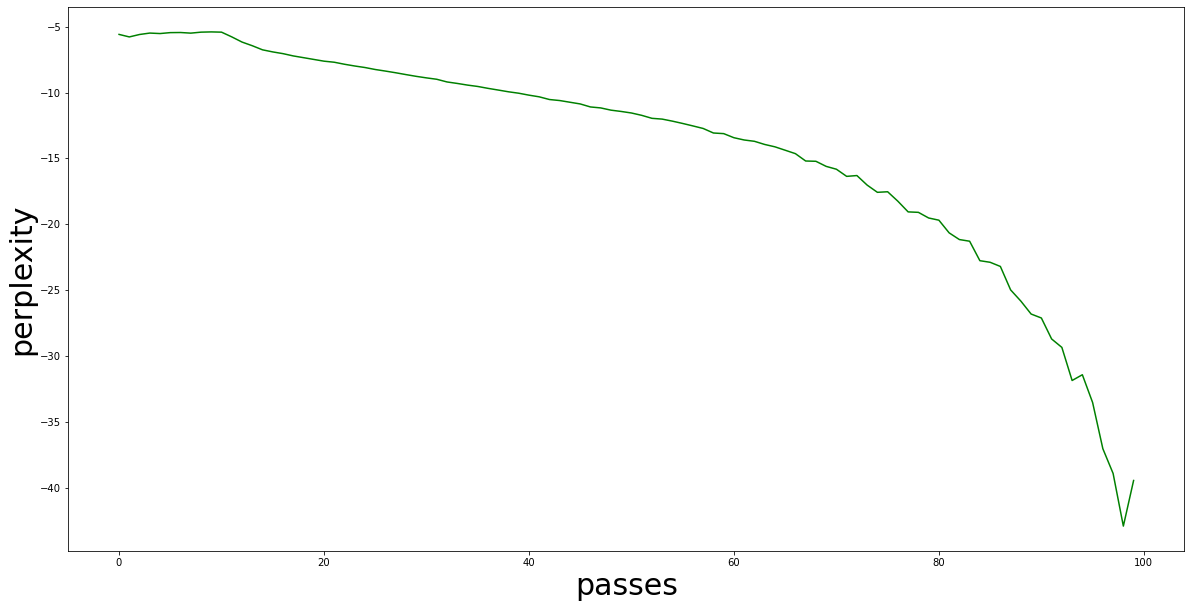

In [14]:
# ldamodel ntopics, perplexity 그래프
plt.figure(figsize=(20, 10))
plt.plot(perplexitiesT,label='ntopics perplexity relationship', color='green')
plt.xlabel('ntopics', fontsize=30)
plt.ylabel('perplexity', fontsize=30)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [19]:
# ldamodel random state 구하기
coherencesR=[]
perplexitiesR=[]
warnings.filterwarnings('ignore')

for i in tqdm(range(100)):
    nwords = 100
    tic = time.time()
    lda4 = LdaModel(corpus, id2word=dictionary, num_topics=73, iterations=400, passes=26, random_state = i)
    print('random_state',i,time.time() - tic)

    cm = CoherenceModel(model=lda4, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence()
    print("Cpherence",coherence)
    coherencesR.append(coherence)
    print('Perplexity: ', lda4.log_perplexity(corpus),'\n\n')
    perplexitiesR.append(lda4.log_perplexity(corpus))

random_state 0 69.28573155403137
Cpherence -18.5377762347271
Perplexity:  -16.897738090574926 


random_state 1 71.59869575500488
Cpherence -18.25312409342767
Perplexity:  -16.61355387824563 


random_state 2 69.86817455291748
Cpherence -18.28390512706452
Perplexity:  -16.837197674300267 


random_state 3 69.5221004486084
Cpherence -18.66211594292882
Perplexity:  -17.350727985100132 


random_state 4 69.1341392993927
Cpherence -18.57914257170086
Perplexity:  -16.88349784435222 


random_state 5 70.44360733032227
Cpherence -18.46118654546258
Perplexity:  -16.753418717083804 


random_state 6 70.77576446533203
Cpherence -18.496245820744264
Perplexity:  -16.698454535996035 


random_state 7 69.20192289352417
Cpherence -18.480329999573897
Perplexity:  -16.76538856374388 


random_state 8 66.93601369857788
Cpherence -18.435315448167884
Perplexity:  -17.129367799208644 


random_state 9 74.06794285774231
Cpherence -18.38030297949309
Perplexity:  -16.942069688611426 


random_state 10 68.7900

random_state 83 67.16739320755005
Cpherence -18.476774738699202
Perplexity:  -16.977060279229438 


random_state 84 70.19729375839233
Cpherence -18.235038424450234
Perplexity:  -16.833197919525844 


random_state 85 67.35193061828613
Cpherence -18.491002957747103
Perplexity:  -17.317713358957832 


random_state 86 67.05669355392456
Cpherence -18.29822150616485
Perplexity:  -16.586167415803327 


random_state 87 66.31268072128296
Cpherence -18.497230509982575
Perplexity:  -16.618038631763596 


random_state 88 66.41238141059875
Cpherence -18.441390172512794
Perplexity:  -17.264027418033987 


random_state 89 65.7222592830658
Cpherence -18.606147996031034
Perplexity:  -17.245816370730804 


random_state 90 68.70333528518677
Cpherence -18.60023495524719
Perplexity:  -16.72822317606539 


random_state 91 70.25015234947205
Cpherence -18.44323718062846
Perplexity:  -16.739565860019596 


random_state 92 73.94926142692566
Cpherence -18.48665337358802
Perplexity:  -16.6859819859315 


random_s

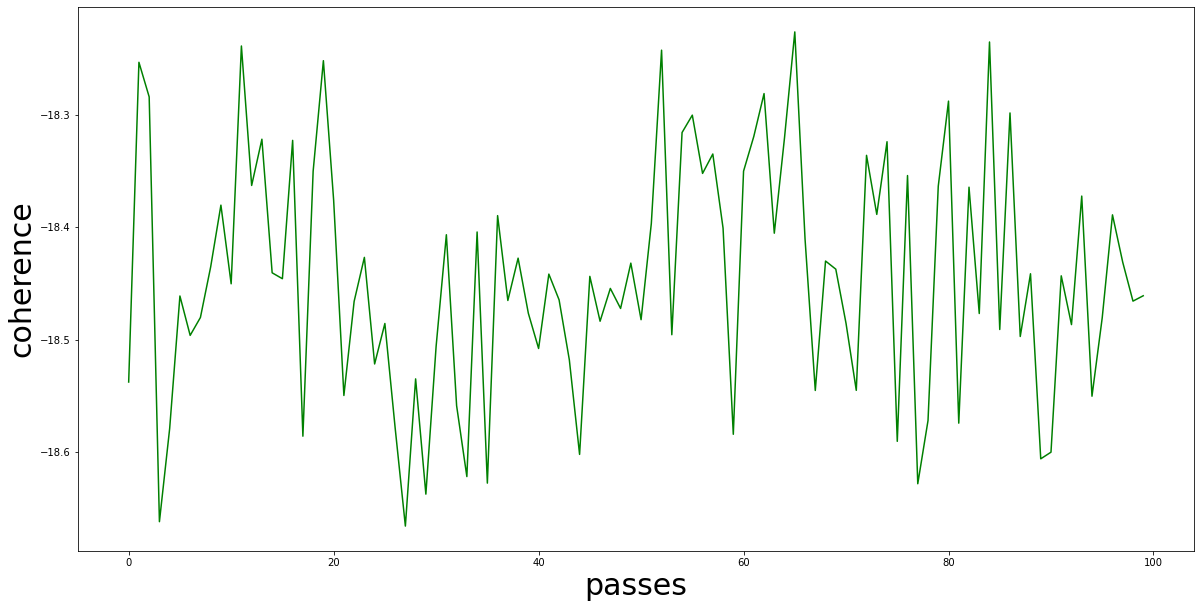

In [20]:
# ldamodel random_state, coherence 그래프
plt.figure(figsize=(20, 10))
plt.plot(coherencesR,label='random_state coherence relationship', color='green')
plt.xlabel('random_state', fontsize=30)
plt.ylabel('coherence', fontsize=30)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

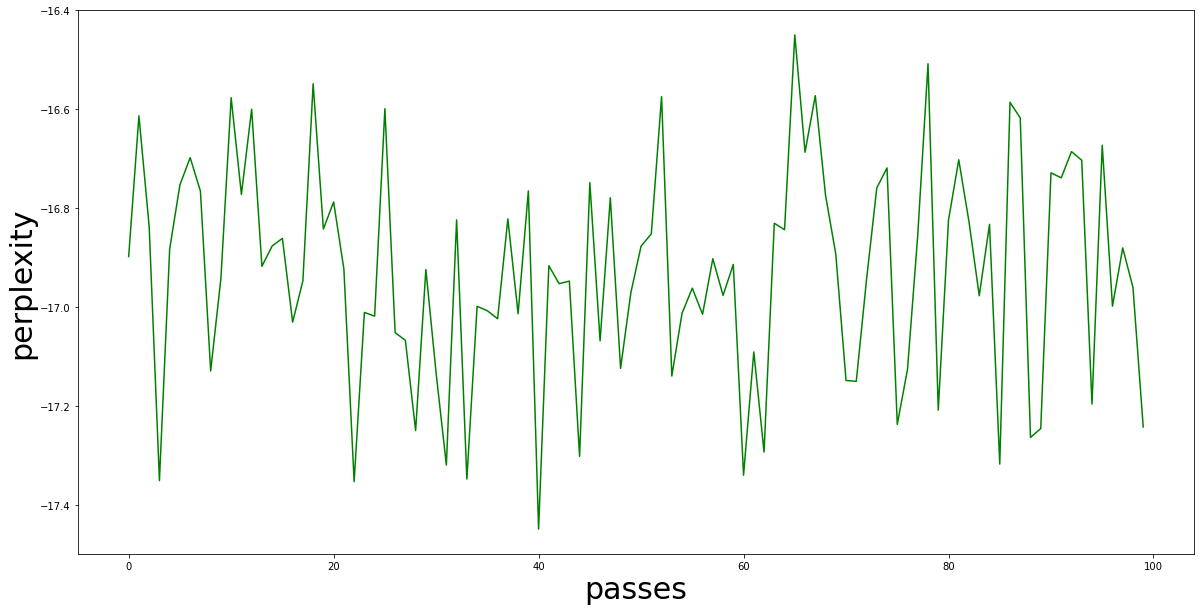

In [21]:
# ldamodel random_state, perplexity 그래프
plt.figure(figsize=(20, 10))
plt.plot(perplexitiesR,label='random_state perplexity relationship', color='green')
plt.xlabel('random_state', fontsize=30)
plt.ylabel('perplexity', fontsize=30)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [ ]:
# NUM_TOPICS = 35
# for i in tqdm(range(100)):
#     ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=50, random_state = i)
#     topics = ldamodel.print_topics(num_words=4)
#     # for topic in topics:

#     #     print(topic)

#     print(f'\n {i} Perplexity:', ldamodel.log_perplexity(corpus))

#     coherence_score_lda = CoherenceModel(model=ldamodel, texts=processed_data, dictionary=dictionary, coherence='c_v')
#     coherence_score = coherence_score_lda.get_coherence()

#     print(f'\n {i} Coherence Score:', coherence_score)

In [23]:
# 위 코드로 구한 최적 parameter를 대입한 ldamodel perplexity, coherence score 출력
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = 73, id2word=dictionary, passes=26, random_state = 27)
topics = ldamodel.print_topics(num_words=4)

print('\nPerplexity:', ldamodel.log_perplexity(corpus))

coherence_score_lda = CoherenceModel(model=ldamodel, texts=processed_data, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_score_lda.get_coherence()

print('\nCoherence Score:', coherence_score)


Perplexity: -17.067669003766902

Coherence Score: 0.5729072943282338


In [24]:
# 클러스터 시각화
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

In [25]:
# topictable dataframe 생성 함수
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame()

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list
        doc = sorted(doc, key=lambda x: (x[1]), reverse=True)
        # 각 문서에 대해서 비중이 높은 토픽순으로 토픽을 정렬한다.
        # EX) 정렬 전 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (10번 토픽, 5%), (12번 토픽, 21.5%), 
        # Ex) 정렬 후 0번 문서 : (2번 토픽, 48.5%), (8번 토픽, 25%), (12번 토픽, 21.5%), (10번 토픽, 5%)
        # 48 > 25 > 21 > 5 순으로 정렬이 된 것.

        # 모든 문서에 대해서 각각 아래를 수행
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            if j == 0:  # 정렬을 한 상태이므로 가장 앞에 있는 것이 가장 비중이 높은 토픽
                topic_table = topic_table.append(pd.Series([int(topic_num), round(prop_topic,4), topic_list]), ignore_index=True)
                # 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중을 저장한다.
            else:
                break
    return(topic_table)

In [26]:
# 모든 여행지의 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중 데이터프레임 생성
topictable = make_topictable_per_doc(ldamodel, corpus)

topictable.columns = ['topic', 'topic_rate', 'topic_list']
topictable

,topic,topic_rate,topic_list
0,65.0,0.5034,"[(37, 0.2534284), (65, 0.5034163)]"
1,40.0,0.7534,"[(40, 0.75342447)]"
2,70.0,0.4027,"[(65, 0.40272892), (70, 0.4027469)]"
3,70.0,0.5034,"[(30, 0.25342417), (70, 0.5034248)]"
4,63.0,0.4193,"[(9, 0.12671228), (16, 0.1960168), (39, 0.1397..."
...,...,...,...
13777,2.0,0.5017,"[(2, 0.50171304), (18, 0.12671234), (35, 0.126..."
13778,55.0,0.8027,"[(55, 0.8027393)]"
13779,68.0,0.6712,"[(68, 0.6712326)]"
13780,33.0,0.6712,"[(33, 0.67123276)]"


In [27]:
# 각 클러스터가 여행지를 몇개 가지는지 count
topictable['topic'].value_counts()

45.0    1594
22.0    1411
67.0    1023
6.0      937
70.0     926
        ... 
24.0       1
17.0       1
37.0       1
1.0        1
21.0       1
Name: topic, Length: 69, dtype: int64

In [28]:
# 기존 여행지 데이터에 topic 데이터프레임 추가
tour_topic = pd.concat([tour, topictable], axis = 1)

In [29]:
tour_topic.head()

,name,region,tel,keyword,photo,address,lat,lon,topic,topic_rate,topic_list
0,(구)강경노동조합,충남 논산시,041-746-5412,등록문화재 건축여행 근대건축물,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,충청남도 논산시 강경읍 옥녀봉로27번길 30-5,36.160849,127.014602,65.0,0.5034,"[(37, 0.2534284), (65, 0.5034163)]"
1,(구)인천일본제58은행지점,인천 중구,032-760-6474,문화재 교과서속여행 역사,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,인천광역시 중구 신포로23번길 77,37.472859,126.621154,40.0,0.7534,"[(40, 0.75342447)]"
2,(구)한일은행 강경지점,충남 논산시,041-746-5412,역사공부 근대건축물 건축여행 역사,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,충청남도 논산시 강경읍 계백로167번길 50,36.162130,127.015154,70.0,0.4027,"[(65, 0.40272892), (70, 0.4027469)]"
3,(전)광주 성거사지 오층석탑,광주 남구,062-607-2333,역사공부 탑 보물 역사관광지,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,광주광역시 남구 천변좌로338번길 7,35.147999,126.908710,70.0,0.5034,"[(30, 0.25342417), (70, 0.5034248)]"
4,(주) 교보문고,서울 종로구,1544-1900,문화행사 도심여행 문화시설 서점 아이와함께 사계절 도서관,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,서울특별시 종로구 종로 1,37.573054,127.016590,63.0,0.4193,"[(9, 0.12671228), (16, 0.1960168), (39, 0.1397..."


In [30]:
tour_topic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13782 entries, 0 to 13781
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        13782 non-null  object 
 1   region      13782 non-null  object 
 2   tel         13782 non-null  object 
 3   keyword     13782 non-null  object 
 4   photo       13782 non-null  object 
 5   address     13782 non-null  object 
 6   lat         13782 non-null  float64
 7   lon         13782 non-null  float64
 8   topic       13782 non-null  float64
 9   topic_rate  13782 non-null  float64
 10  topic_list  13782 non-null  object 
dtypes: float64(4), object(7)
memory usage: 1.2+ MB


In [31]:
tour_topic.set_index('name', inplace = True)

In [32]:
tour_topic.head()

,region,tel,keyword,photo,address,lat,lon,topic,topic_rate,topic_list
name,,,,,,,,,,
(구)강경노동조합,충남 논산시,041-746-5412,등록문화재 건축여행 근대건축물,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,충청남도 논산시 강경읍 옥녀봉로27번길 30-5,36.160849,127.014602,65.0,0.5034,"[(37, 0.2534284), (65, 0.5034163)]"
(구)인천일본제58은행지점,인천 중구,032-760-6474,문화재 교과서속여행 역사,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,인천광역시 중구 신포로23번길 77,37.472859,126.621154,40.0,0.7534,"[(40, 0.75342447)]"
(구)한일은행 강경지점,충남 논산시,041-746-5412,역사공부 근대건축물 건축여행 역사,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,충청남도 논산시 강경읍 계백로167번길 50,36.162130,127.015154,70.0,0.4027,"[(65, 0.40272892), (70, 0.4027469)]"
(전)광주 성거사지 오층석탑,광주 남구,062-607-2333,역사공부 탑 보물 역사관광지,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,광주광역시 남구 천변좌로338번길 7,35.147999,126.908710,70.0,0.5034,"[(30, 0.25342417), (70, 0.5034248)]"
(주) 교보문고,서울 종로구,1544-1900,문화행사 도심여행 문화시설 서점 아이와함께 사계절 도서관,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,서울특별시 종로구 종로 1,37.573054,127.016590,63.0,0.4193,"[(9, 0.12671228), (16, 0.1960168), (39, 0.1397..."


In [33]:
tour_topic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13782 entries, (구)강경노동조합 to 힐튼양복점
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      13782 non-null  object 
 1   tel         13782 non-null  object 
 2   keyword     13782 non-null  object 
 3   photo       13782 non-null  object 
 4   address     13782 non-null  object 
 5   lat         13782 non-null  float64
 6   lon         13782 non-null  float64
 7   topic       13782 non-null  float64
 8   topic_rate  13782 non-null  float64
 9   topic_list  13782 non-null  object 
dtypes: float64(4), object(6)
memory usage: 1.2+ MB


In [35]:
# csv 파일 생성
tour_topic.to_csv("./final_data/LDA_gensim_topic.csv", mode='w', encoding ='utf-8-sig')

In [36]:
# 키워드 입력
documents_input = []
keyword_input = input().split()

# dictionary를 활용하여 입력한 키워드가 들어간 키워드는 keyword_str에 모두 포함되도록 함
keyword_str = ""
for i in range(len(dictionary)):
    for k in keyword_input:
        if k in dictionary[i]:
            keyword_str += dictionary[i] + " "

keyword_input = keyword_str.split()
documents_input.append(keyword_input)
corpus_input = [dictionary.doc2bow(text) for text in documents_input]
topictable_input = make_topictable_per_doc(ldamodel, corpus_input)
topictable_input.columns = ['topic', 'topic_rate', 'topic_list']
# 입력 키워드에 대한 가장 비중이 높은 토픽과, 가장 비중이 높은 토픽의 비중과, 전체 토픽의 비중 출력
topictable_input

바다


,topic,topic_rate,topic_list
0,43.0,0.5017,"[(10, 0.12671272), (43, 0.5017133), (59, 0.126..."


In [37]:
# 입력한 키워드의 토픽에 해당하는 여행지만 가져옴
topic_result = topictable_input['topic'][0]
tour_topic_keyword = tour_topic[tour_topic['topic'] == topic_result]

In [38]:
tour_topic_keyword

,region,tel,keyword,photo,address,lat,lon,topic,topic_rate,topic_list
name,,,,,,,,,,
가진해변,강원 고성군,033-680-3356,바다풍경 바다낚시 해변 바다내음,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,강원도 고성군 죽왕면 가진해변길,38.371473,128.506905,43.0,0.4027,"[(0, 0.20273815), (10, 0.20274019), (43, 0.402..."
거제 쌍근어촌체험마을,경남 거제시,010-9719-4115,바다낚시 바다전망 바다체험 가족과함께 바다내음,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,경상남도 거제시 남부면 남부해안로 1094,34.762406,128.589475,43.0,0.8356,"[(43, 0.835616)]"
경복궁,서울 종로구,02-3700-3900,고궁 가족과함께,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,서울특별시 종로구 사직로 161,37.577362,126.976684,43.0,0.6712,"[(43, 0.67123145)]"
경주 양남 주상절리 전망대,경북 경주시,054-775-6366,바다풍경 바다전망 가족과함께경치좋은곳 바다내음,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,경상북도 경주시 양남면 읍천리,35.692003,129.465858,43.0,0.5034,"[(10, 0.25342494), (43, 0.50342387)]"
경희궁,서울 종로구,02-724-0274,고궁 가족과함께,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,서울특별시 종로구 새문안로 55,37.570057,126.970531,43.0,0.6712,"[(43, 0.67123145)]"
공수어촌체험마을,부산 기장군,051-723-1919,마을 바다낚시 바다체험 아이와함께,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,부산광역시 기장군 기장읍 공수해안길 13-2,35.184404,129.211195,43.0,0.4027,"[(15, 0.20273909), (33, 0.2027402), (43, 0.402..."
광화문,서울 종로구,02-3700-3900,고궁 문화재 가족과함께,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,서울특별시 종로구 사직로 161,37.577362,126.976684,43.0,0.5034,"[(40, 0.25342524), (43, 0.5034228)]"
낙산항,강원 양양군,033-670-2411,어촌마을 여행 바다낚시 바다 바다내음 바다경치,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,강원도 양양군 강현면 전진리,38.123507,128.626488,43.0,0.2877,"[(18, 0.14481209), (43, 0.28767258), (51, 0.14..."
대항 어촌체험 휴양마을,부산 강서구,010-3570-1036,바다풍경 바다낚시 바다전망 바다체험 아이와함께 바다내음,https://cdn.visitkorea.or.kr/img/call?cmd=VIEW...,부산광역시 강서구 가덕해안로1207번길 9-2,35.011661,128.827655,43.0,0.5734,"[(10, 0.14481413), (33, 0.14481412), (43, 0.57..."
